<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/1_KG_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 1: Graph Thinking & Building a KG from Structured Data

**Objective:** This notebook will guide you through the fundamentals of graph thinking. You'll use the `networkx` library to build a Knowledge Graph (KG) from the structured MovieLens dataset and then develop several recommendation algorithms that leverage the graph's structure.

## 📚 1. Setup and Environment

First, let's install the necessary libraries and import them into our environment.

In [ ]:
# Install required Python libraries quietly
!uv pip install networkx pandas matplotlib scikit-learn karateclub


Audited 5 packages in 1.56s


In [ ]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from karateclub import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
import warnings

# Default settings for visualizations and output
plt.style.use('default')
warnings.filterwarnings('ignore')

print("✅ Libraries installed and imported successfully!")

✅ Libraries installed and imported successfully!


## 🧠 2. The Basics of Graph Thinking

A Knowledge Graph represents entities as **nodes** (e.g., people, products, movies) and the relationships between them as **edges** (e.g., `FRIENDS_WITH`, `PURCHASED`, `ACTED_IN`).

To build and work with these structures in Python, we'll use **`networkx`**, a powerful and popular library specifically designed for creating, manipulating, and studying complex networks. It provides an intuitive way to define nodes and edges, attach data (attributes) to them, and prepare the graph for analysis and visualization. We'll import it using its standard alias, `nx`.

Let's build a tiny graph from scratch to see how it works.

Nodes: [('The Matrix', {'type': 'Movie', 'year': 1999}), ('Keanu Reeves', {'type': 'Actor', 'birth_year': 1964})]
Edges: [('The Matrix', 'Keanu Reeves', {'role': 'Neo'})]


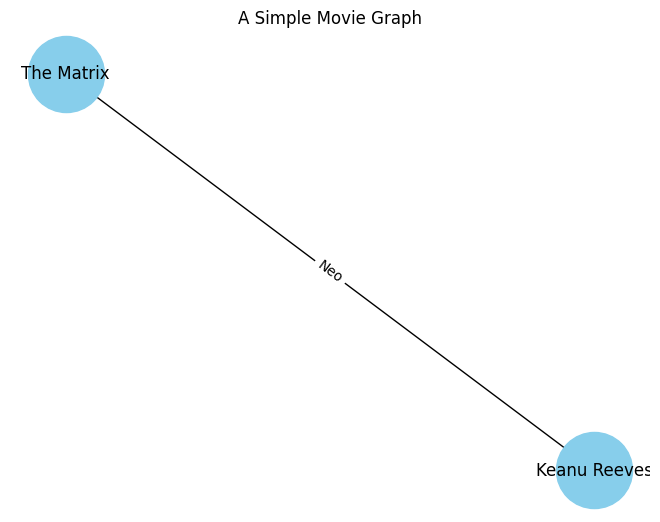

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes with attributes (properties)
G.add_node("The Matrix", type="Movie", year=1999)
G.add_node("Keanu Reeves", type="Actor", birth_year=1964)

# Add an edge with attributes to define the relationship
G.add_edge("Keanu Reeves", "The Matrix", role="Neo")

# Check our graph's contents
print("Nodes:", G.nodes(data=True))
print("Edges:", G.edges(data=True))

# Visualize the simple graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12)
edge_labels = nx.get_edge_attributes(G, 'role')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("A Simple Movie Graph")
plt.show()

## 🏗️ 3. Building a Movie Knowledge Graph

Now, we'll apply this concept at a larger scale by converting structured data (CSV files) into a knowledge graph. Our goal is to create a graph containing `(:Movie)` and `(:User)` nodes connected by `[:RATED]` edges.

### Data Loading

For this project, we'll use the well-known **MovieLens dataset** 📊, a collection of movie ratings collected by the GroupLens research group at the University of Minnesota. We're using the "small" version, which is ideal for demonstration. It consists of two main files:

* **`movies.csv`**: Contains movie information. Each row represents one movie and includes its unique `movieId`, `title`, and `genres`. This file will provide the data for our **`(:Movie)` nodes** and their properties.
* **`ratings.csv`**: This is the core interaction data. It contains records of users rating movies. Each row includes a `userId`, a `movieId`, the `rating` given (on a 5-star scale), and a `timestamp`. This file is crucial for creating our **`(:User)` nodes** and the **`[:RATED]` edges** that connect users to the movies they've reviewed.

First, we download the dataset and load these CSV files into pandas DataFrames.

In [ ]:
# Download and unzip the dataset
!wget -q http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip


Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:

# Load data into DataFrames
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')

print("✅ MovieLens dataset loaded successfully!")
print("\nMovies DataFrame:")
display(movies_df.head())
print("\nRatings DataFrame:")
display(ratings_df.head())

✅ MovieLens dataset loaded successfully!

Movies DataFrame:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings DataFrame:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Graph Construction

We'll iterate through the DataFrames to populate our graph. To avoid conflicts where a user ID might be the same as a movie ID, we'll add prefixes (`u_` for users, `m_` for movies).

In [ ]:
# Create a new, empty graph
MovieKG = nx.Graph()

# 1. Add movie nodes from the movies_df
for _, row in movies_df.iterrows():
    movie_id = f"m_{row['movieId']}"
    MovieKG.add_node(
        movie_id,
        type='Movie',
        title=row['title'],
        genres=row['genres']
    )

# 2. Add user nodes and the 'RATED' edges from ratings_df
for _, row in ratings_df.iterrows():
    user_id = f"u_{int(row['userId'])}"
    movie_id = f"m_{int(row['movieId'])}"

    # Add the user node (networkx handles duplicates automatically)
    MovieKG.add_node(user_id, type='User')

    # Add the edge connecting the user and the movie
    MovieKG.add_edge(
        user_id,
        movie_id,
        rating=row['rating'],
        timestamp=row['timestamp']
    )

print(f"✅ Knowledge Graph built successfully!")
print(f"Total nodes: {MovieKG.number_of_nodes():,}")
print(f"Total edges: {MovieKG.number_of_edges():,}")

✅ Knowledge Graph built successfully!
Total nodes: 10,352
Total edges: 100,836


### Visualizing a Subgraph

Visualizing the entire graph of over 100,000 ratings would be chaotic. Instead, let's create a subgraph to see the "movie universe" for a single user.

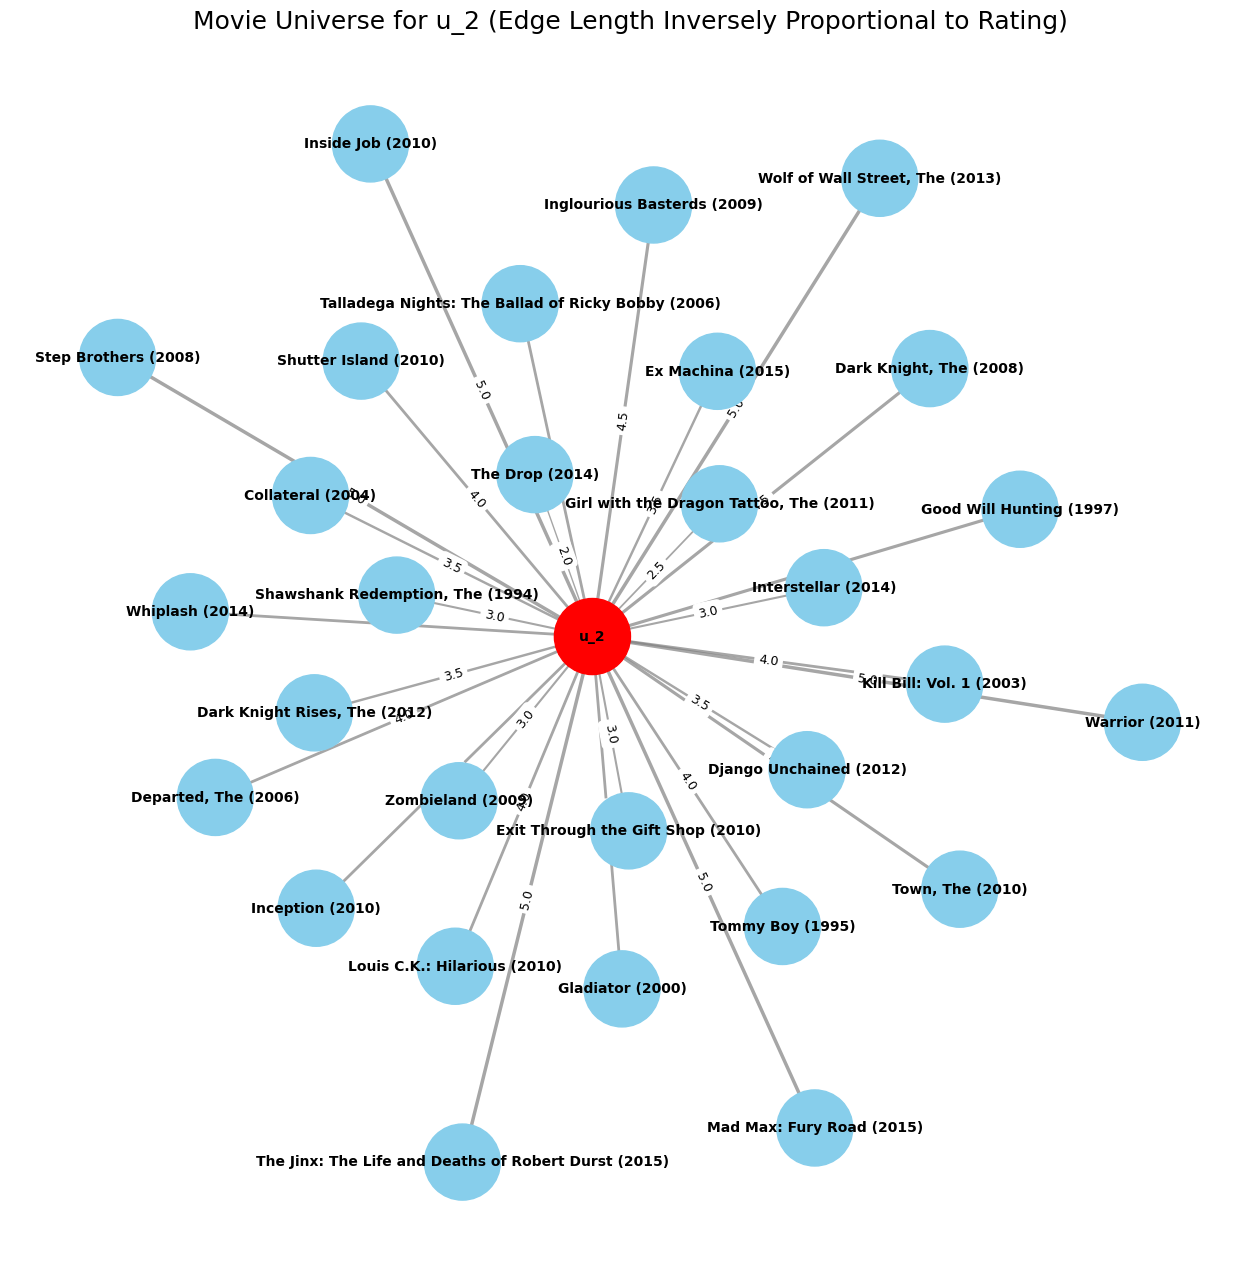

In [ ]:
def draw_user_movie_subgraph(graph, user_id):
    """
    Creates and draws a subgraph for a specific user, where edge length
    is directly proportional to the movie rating (higher rating = longer edge).
    """
    if not graph.has_node(user_id):
        print(f"Error: User '{user_id}' not found.")
        return

    # Get all movies connected to the user
    movie_nodes = list(graph.neighbors(user_id))
    subgraph_nodes = [user_id] + movie_nodes

    # Create the subgraph containing only these nodes
    subG = graph.subgraph(subgraph_nodes)

    # --- Prepare INVERTED edge weights for layout ---
    # We now want higher ratings to result in LONGER edge lengths (weaker pull).
    # We calculate weight as (6.0 - rating).
    for u, v, data in subG.edges(data=True):
        rating = data.get('rating', 3.0) # Default to a neutral rating if missing
        # A high rating (e.g., 5) gives a low weight (1), resulting in a longer distance.
        # A low rating (e.g., 1) gives a high weight (5), resulting in a shorter distance.
        data['layout_weight'] = 6.0 - rating

    # --- Visualization Setup ---
    plt.figure(figsize=(16, 16))

    # The layout now uses the inverted weight.
    pos = nx.spring_layout(subG, seed=42, k=0.8, weight='layout_weight', iterations=50)

    # Color nodes by type (User or Movie)
    node_colors = ['red' if subG.nodes[n]['type'] == 'User' else 'skyblue' for n in subG.nodes()]
    node_labels = {n: subG.nodes[n].get('title', n) for n in subG.nodes()}

    # Draw the graph elements
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=3000)
    nx.draw_networkx_labels(subG, pos, labels=node_labels, font_size=10, font_weight='bold')

    edge_widths = [d['rating'] / 2.0 for u, v, d in subG.edges(data=True)]
    nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.7, edge_color='gray')

    edge_labels = nx.get_edge_attributes(subG, 'rating')
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='black', font_size=9)

    plt.title(f"Movie Universe for {user_id} (Edge Length Inversely Proportional to Rating)", size=18)
    plt.axis('off')
    plt.show()

# Visualize the graph for User 'u_1' with the inverted layout
draw_user_movie_subgraph(MovieKG, user_id='u_2')

## 💡 4. Recommendation Strategies

Now that we have a KG, we can use its structure to build different types of recommendation engines.

### Strategy 1: 🎬 Content-Based Filtering

This method recommends movies based on the **properties of items** a user has liked. Think of it as a digital curator that learns your specific tastes. If you tell it you love action movies directed by Christopher Nolan, it will find other action movies, or perhaps other films by the same director, rather than suggesting a romantic comedy. It operates on the principle: "Show me more of what I like."

The "content" refers to the **metadata** or **attributes** of the items themselves. In our case, for a `(:Movie)` node, these properties include:

* **Genres** (e.g., Action, Sci-Fi, Thriller)
* **Title** (which could be analyzed for keywords)
* Other potential attributes could be actors, directors, or plot summaries.

---

### How It Works in Our Movie KG

The process involves creating a personalized "taste profile" for each user based on their rating history.

1.  **Analyze User History**: First, we look at the movies a user has rated highly (e.g., 4 stars or above). These ratings are strong signals of what the user enjoys.

2.  **Build a Taste Profile**: We then extract the genres from these highly-rated movies and aggregate them. For example, if a user loves *The Dark Knight* (Action|Crime|Drama), *Inception* (Action|Sci-Fi|Thriller), and *The Prestige* (Drama|Mystery|Sci-Fi), their taste profile would be heavily weighted towards **Action**, **Sci-Fi**, and **Drama**. In our code, this profile is a `Counter` object that stores how many times each genre appeared in their favorite films.

3.  **Score and Rank Candidates**: Next, we look at all the movies the user *hasn't* seen yet. We score each of these candidate movies based on how well their genres match the user's taste profile. A movie with genres that frequently appear in the user's profile will receive a higher score.

4.  **Recommend**: Finally, we present the user with the top-scoring movies, which are the ones that most closely match their established tastes.

---

### Strengths and Weaknesses

👍 **Strengths**:

* **User Independence**: Recommendations are specific to a user and don't rely on data from other users. This means it can recommend niche items that other methods might miss.
* **Explainability**: The recommendations are transparent. We can easily explain *why* a movie was recommended (e.g., "Because you liked other Sci-Fi movies").
* **No "New Item" Problem**: As soon as a new movie with genre metadata is added to the database, it can be recommended to relevant users immediately, without needing any user ratings first.

👎 **Weaknesses**:

* **Limited Serendipity**: The system tends to recommend items that are very similar to what a user has already seen. It's less likely to help a user discover a completely new taste, potentially creating a "filter bubble."
* **Requires Rich Metadata**: The quality of recommendations is highly dependent on the quality and detail of the item properties. If the genre information is sparse or inaccurate, the recommendations will suffer.
* **The "New User" Problem**: It cannot make recommendations to a new user with no rating history, as there is no data to build a taste profile from.

In [ ]:
def recommend_by_content(graph, user_id, num_recs=5):
    """Recommends movies based on the genres of movies the user has highly rated."""
    if not graph.has_node(user_id): return f"User {user_id} not found."

    # 1. Create the user's "taste profile" from genres of movies rated 4.0 or higher.
    taste_profile = Counter()
    user_rated_movies = set(graph.neighbors(user_id))
    for movie in user_rated_movies:
        if graph.edges[user_id, movie]['rating'] >= 4.0:
            genres = graph.nodes[movie].get('genres', '').split('|')
            taste_profile.update(genres)

    # 2. Score candidate movies based on how well their genres match the taste profile.
    recommendations = {}
    all_movies = {n for n, d in graph.nodes(data=True) if d['type'] == 'Movie'}

    for movie in all_movies - user_rated_movies:
        movie_genres = set(graph.nodes[movie].get('genres', '').split('|'))
        score = sum(taste_profile[genre] for genre in movie_genres)
        if score > 0:
            recommendations[movie] = score

    # 3. Sort and return the top recommendations.
    sorted_recs = sorted(recommendations.items(), key=lambda item: item[1], reverse=True)
    return {graph.nodes[mid]['title']: score for mid, score in sorted_recs[:num_recs]}

### Strategy 2: 🛤️ Collaborative Filtering (Path-Based)

This method operates on the principle that **"users who agree in the past will agree in the future."** Instead of looking at the content of the movies, it leverages the power of the community. Think of it like getting a recommendation from a friend: if you both love the movie *Inception*, and your friend then tells you to watch *The Prestige*, you're likely to trust their recommendation because you share similar tastes.

In our Knowledge Graph, these "social" connections are represented by **paths**. The most common and powerful pattern for this type of recommendation is:

`User A → Movie X ← User B → Movie Y`

Let's break down what this path means:
1.  **`User A → Movie X`**: Your target user (User A) has rated a movie (Movie X) highly.
2.  **`Movie X ← User B`**: Another user (User B) has *also* rated that same movie (Movie X) highly. This shared positive rating establishes User B as a "taste neighbor" or a similar user to User A.
3.  **`User B → Movie Y`**: This similar user (User B) has also rated another movie (Movie Y) highly.
4.  **The Inference**: Because User A and User B share a common interest in Movie X, there's a good chance that User A will also enjoy Movie Y. The existence of this path forms the basis for a recommendation.

---

### How It Works in Our Movie KG

Our algorithm essentially becomes a "path counter." It explores the graph to find how many of these collaborative paths lead to movies the target user hasn't seen yet.

1.  **Find Strong Signals**: We start by looking only at high ratings (e.g., >= 4.0 stars) to identify movies the user genuinely likes.
2.  **Identify Similar Users**: For each movie the target user loves, we traverse the graph to find all other users who also loved that same movie. These are the "taste neighbors."
3.  **Discover Potential Recommendations**: We then look at the other movies these taste neighbors have loved.
4.  **Count the Paths and Rank**: Each time we discover a new movie through this `User → Movie ← User → Movie` pattern, we increment a counter for that movie. A movie that is recommended by many different "taste neighbors" will have a high count.
5.  **Recommend**: Finally, we present the movies with the highest path counts as the top recommendations.

---

### Strengths and Weaknesses

👍 **Strengths**:

* **Serendipity and Novelty**: This approach can uncover unexpected recommendations. For example, it might connect a sci-fi movie to a historical drama if the same group of users happens to like both. It's great for helping users discover new interests.
* **No Item Metadata Needed**: The recommendations are generated purely from user interaction data (ratings). It doesn't matter if we know the genre, director, or actors of a movie.

👎 **Weaknesses**:

* **The "Cold Start" Problem**: This is a major challenge for collaborative filtering.
    * **New User Problem**: A new user with no ratings has no connections in the graph, making it impossible to find similar users.
    * **New Item Problem**: A new movie that hasn't been rated by anyone will never appear in a path and cannot be recommended.
* **Data Sparsity**: If the dataset is sparse (i.e., users have rated very few movies), it can be difficult to find other users with overlapping tastes, which weakens the algorithm's effectiveness.
* **Popularity Bias**: The system has a natural tendency to recommend movies that are already popular, as these items will have the most ratings and thus appear in more paths. Niche or "long-tail" items may be underrepresented.

In [ ]:
def recommend_by_path(graph, user_id, num_recs=5):
    """Implements collaborative filtering by counting shared paths: User -> Movie <- User -> Movie."""
    if not graph.has_node(user_id): return f"User {user_id} not found."

    # For this method, let's only consider strong signals (ratings >= 4.0)
    strong_links_graph = nx.Graph(((u, v) for u, v, d in graph.edges(data=True) if d['rating'] >= 4.0))

    target_user_movies = set(strong_links_graph.neighbors(user_id))
    recommendations = Counter()

    # Find users who also liked the same movies
    for movie in target_user_movies:
        for similar_user in strong_links_graph.neighbors(movie):
            if similar_user == user_id:
                continue

            # Find movies the similar user liked that the target user hasn't seen
            for rec_movie in strong_links_graph.neighbors(similar_user):
                if rec_movie not in target_user_movies:
                    recommendations[rec_movie] += 1

    # Format and return the top N recommendations
    sorted_recs = recommendations.most_common(num_recs)
    return {graph.nodes[mid]['title']: count for mid, count in sorted_recs}


### Strategy 3: 👥 Community-Based Filtering

This approach is a sophisticated evolution of collaborative filtering. Instead of just finding one-to-one "taste neighbors," it identifies entire **"taste communities"** within the graph. Think of it as finding your cinematic tribe—a whole group of users who share a similar pattern of liked movies—and then recommending what's popular within that tribe.

In graph theory, a community is a group of nodes that are more densely connected to each other than to nodes outside the group. In our movie KG, this translates to clusters of users and movies linked by many high ratings. We can automatically discover these clusters using **community detection algorithms**. One of the most effective and widely used is the **Louvain method**, which we'll use here.

-----

### How It Works in Our Movie KG

The process involves identifying these taste clusters and then leveraging their collective wisdom.

1.  **Filter for Strong Links**: To find meaningful communities, we first simplify the graph. We create a new subgraph that only includes "strong links"—edges representing high ratings (e.g., 4 stars or more). This focuses the algorithm on genuine "likes," filtering out the noise from mediocre or negative ratings.
2.  **Detect Communities**: We run the Louvain community detection algorithm on this "strong links" graph. The algorithm partitions all the nodes (both users and movies) into distinct communities.
3.  **Find the User's Community**: Once the communities are identified, we locate the specific community that our target user belongs to.
4.  **Aggregate and Rank**: We then look at all the *other* users within this same community and aggregate a list of all the movies they have liked. We count how many times each movie appears.
5.  **Recommend**: Finally, we recommend the movies that are most popular within the user's community, making sure to exclude any movies the user has already seen.

-----

### Strengths and Weaknesses

👍 **Strengths**:

  * **Nuanced Recommendations**: This method can capture more subtle, group-level patterns than simple collaborative filtering. It recommends what is popular within a specific "niche" rather than just looking at global popularity.
  * **Robustness**: Recommendations are based on the consensus of an entire group, making them potentially more reliable and less susceptible to the influence of a few outlier users.
  * **Serendipity**: It can introduce users to movies that are popular within their specific taste cluster but might not be globally famous, leading to novel discoveries.

👎 **Weaknesses**:

  * **The "Cold Start" Problem**: Like other collaborative methods, it cannot generate recommendations for new users who haven't rated enough movies to be placed in a community.
  * **Community Granularity**: The size and quality of detected communities can vary. A user might be placed in a very large, generic community (e.g., "blockbuster action movie fans") or one that is too small to provide diverse recommendations.
  * **Bridging Tastes**: A user might have diverse tastes that span multiple communities (e.g., they love both obscure horror films and classic musicals). This method typically assigns a user to only one community, potentially ignoring their other interests.



In [ ]:

def recommend_by_community(graph, user_id, num_recs=5):
    """Finds the user's taste community and recommends movies popular within it."""
    if not graph.has_node(user_id): return f"User {user_id} not found."

    # Step 1: Create a subgraph of only "strong links" (high ratings) for better community detection.
    strong_links_graph = nx.Graph()
    for u, v, data in graph.edges(data=True):
        if data['rating'] >= 4.0:
            strong_links_graph.add_node(u, **graph.nodes[u])
            strong_links_graph.add_node(v, **graph.nodes[v])
            strong_links_graph.add_edge(u, v)

    # Step 2: Detect communities using the Louvain method.
    # This partitions the graph into a list of communities (sets of nodes).
    communities = list(nx.community.louvain_communities(strong_links_graph))

    # Step 3: Find the community the target user belongs to.
    user_community = None
    for community in communities:
        if user_id in community:
            user_community = community
            break

    if not user_community: return "User does not belong to a strong taste community."

    # Step 4: Find movies popular in the community that the user hasn't seen.
    user_rated_movies = set(graph.neighbors(user_id))
    community_movie_counter = Counter()

    # Iterate through each member of the user's community
    for member in user_community:
        # We only want recommendations from other USERS in the community
        if graph.nodes[member]['type'] == 'User' and member != user_id:
            # Find all movies this similar user has rated
            for movie_node in graph.neighbors(member):
                # Add the movie to our counter if the target user hasn't seen it
                if movie_node not in user_rated_movies:
                    community_movie_counter[movie_node] += 1

    # Step 5: Sort and return the top recommendations based on popularity within the community.
    sorted_recs = community_movie_counter.most_common(num_recs)
    return {graph.nodes[mid]['title']: count for mid, count in sorted_recs}


### Strategy 4: 🧠 Embedding-Based Filtering

This is a powerful, modern approach that uses machine learning to translate the graph's structure into a mathematical space. The core idea is to learn a **vector representation** (also called an **embedding**) for every single node in our graph.

Think of it like creating a detailed map of a city. Instead of just knowing that two locations are connected by a road (an edge), you assign each location a precise set of coordinates (a vector). On this map, locations that are part of the same neighborhood will have coordinates that are numerically close to each other.

Similarly, in our "taste map," a user node and the movie nodes they like will be placed close together. Users with similar tastes will also end up in the same region of this map. This allows us to make recommendations by simply finding which movies are "closest" to a user on the map.

---

### How It Works: Learning from Random Walks

We use an algorithm called **`Node2Vec`** to generate these embeddings. It learns the "position" of each node by performing thousands of short, random walks across the graph.

1.  **Simulate Browsing Sessions**: A "random walk" is like simulating a user's journey through the graph. Starting from a node, it randomly hops to one of its neighbors, then to one of that node's neighbors, and so on, creating a path like: `User A → Movie X → User B → Movie Y → User C`.

2.  **Learn from Context**: The fundamental principle is that **nodes that frequently appear in the same walks are related**. The algorithm processes these thousands of walk paths and learns that if "User A" and "Movie Y" often show up in the same context (i.e., in the same random walks), they must be similar in some way. It then adjusts their vectors to be mathematically closer. This process captures not just direct connections but also more complex, multi-step relationships.

3.  **Generate the Embeddings**: After training, every node (both users and movies) is assigned a vector of a fixed size (e.g., 16 numbers). This vector is a dense numerical representation of that node's position and role within the graph's structure.

4.  **Calculate Similarity**: To make a recommendation, we take the vector for our target user. Then, using a metric called **cosine similarity**, we calculate the "similarity" between the user's vector and the vector for every movie they haven't seen. Cosine similarity measures the angle between two vectors; a smaller angle means a higher similarity.

5.  **Recommend**: The movies with the highest similarity scores are the top recommendations.

---

### Strengths and Weaknesses

👍 **Strengths**:

* **Captures Latent Features**: This method is incredibly powerful because it can learn **implicit** or **latent** relationships that aren't explicitly defined. For example, it might place two movies close together not because they share a genre, but because they have a similar "feel" or appeal to the same nuanced taste community, something that is very hard to capture with metadata alone.
* **High Performance**: Once the embeddings are trained (which is a one-time, offline cost), generating recommendations is extremely fast. Calculating cosine similarity between vectors is a highly optimized mathematical operation.
* **Handles Complex Structures**: It's very effective at understanding the rich, complex structure of a large graph.

👎 **Weaknesses**:

* **"Black Box" Nature**: The recommendations are less explainable. It's difficult to pinpoint *exactly why* the model decided two nodes were similar, as the vector dimensions don't correspond to human-understandable concepts like "genre" or "actor."
* **Computationally Expensive Training**: The initial process of training the model by performing thousands of random walks and learning the vectors is computationally intensive and time-consuming, which is why we downsample our data for this demonstration.
* **The "Cold Start" Problem**: Like collaborative methods, it cannot generate an embedding for a new user or item that has no connections in the graph.

In [ ]:
# --- Setup for Embedding-Based Method ---
print(f"Original ratings count: {len(ratings_df)}")
ratings_df_sampled = ratings_df.sample(frac=0.3, random_state=42)
print(f"Downsampled ratings count: {len(ratings_df_sampled)}")

# Build a new graph with integer IDs, as required by the karateclub library
SampledKG = nx.Graph()
user_map, movie_map = {}, {} # Maps original ID -> new integer ID
node_counter = 0

# Add movie and user nodes from the SAMPLED data
for _, row in ratings_df_sampled.iterrows():
    if row['rating'] >= 4.0: # Only model strong "likes"
        user_id_orig, movie_id_orig = int(row['userId']), int(row['movieId'])

        # Get movie title
        title = movies_df[movies_df['movieId'] == movie_id_orig]['title'].iloc[0]

        # Map original IDs to new integer IDs
        if user_id_orig not in user_map:
            user_map[user_id_orig] = node_counter
            SampledKG.add_node(node_counter, type='User')
            node_counter += 1
        if movie_id_orig not in movie_map:
            movie_map[movie_id_orig] = node_counter
            SampledKG.add_node(node_counter, type='Movie', title=title)
            node_counter += 1

        SampledKG.add_edge(user_map[user_id_orig], movie_map[movie_id_orig])

print(f"\n✅ Downsampled KG built: {SampledKG.number_of_nodes()} nodes, {SampledKG.number_of_edges()} edges.")

# --- Train Node2Vec Model ---
print("\nTraining node embeddings...")
model = Node2Vec(dimensions=16, walk_length=10, walk_number=20, workers=4)
model.fit(SampledKG)
embeddings = {node: model.get_embedding()[i] for i, node in enumerate(SampledKG.nodes())}
print("✅ Embeddings trained.")



Original ratings count: 100836
Downsampled ratings count: 30251

✅ Downsampled KG built: 4259 nodes, 14481 edges.

Training node embeddings...
✅ Embeddings trained.


In [ ]:

def recommend_by_embedding(graph, embeddings, user_id_orig, num_recs=5):
    """Recommends movies using cosine similarity of node embeddings."""
    if user_id_orig not in user_map: return f"User {user_id_orig} not in sampled data."
    user_node_id = user_map[user_id_orig]

    user_vector = embeddings[user_node_id]
    user_rated_movies = set(graph.neighbors(user_node_id))

    # Calculate similarity between the user and all movies
    movie_nodes = [n for n, d in graph.nodes(data=True) if d['type'] == 'Movie']
    movie_vectors = np.array([embeddings[node] for node in movie_nodes])
    similarities = cosine_similarity(user_vector.reshape(1, -1), movie_vectors)[0]

    # Create a dictionary of unseen movies and their scores
    unseen_scores = {
        movie: sim for movie, sim in zip(movie_nodes, similarities) if movie not in user_rated_movies
    }

    # Sort and return the top recommendations
    sorted_recs = sorted(unseen_scores.items(), key=lambda item: item[1], reverse=True)
    return {graph.nodes[mid]['title']: score for mid, score in sorted_recs[:num_recs]}

-----

## ✨ 5. Execution: Get Recommendations

Finally, let's pick a target user and see what each recommendation strategy suggests.

In [ ]:
TARGET_USER_PREFIXED = 'u_2'  # For methods using the full graph
TARGET_USER_ORIGINAL = 2      # For the embedding method using the sampled graph

print("="*60)
print(f"RECOMMENDATIONS FOR USER: {TARGET_USER_PREFIXED}")
print("="*60 + "\n")

# --- Strategy 1: Content-Based Recommendations ---
print("🎬 Based on Content (Your Genre Taste Profile):")
content_recs = recommend_by_content(MovieKG, TARGET_USER_PREFIXED)
for title, score in content_recs.items():
    print(f"  - {title} (Genre Score: {score})")

# --- Strategy 2: Collaborative Filtering (Path-Based) ---
print("\n🛤️ Based on Collaborative Paths (Taste Neighbors):")
path_recs = recommend_by_path(MovieKG, TARGET_USER_PREFIXED)
for title, count in path_recs.items():
    print(f"  - {title} (Found via {count} shared paths)")

# --- Strategy 3: Community-Based Filtering ---
print("\n👥 Based on Your Taste Community:")
community_recs = recommend_by_community(MovieKG, TARGET_USER_PREFIXED)
if isinstance(community_recs, dict):
    for title, count in community_recs.items():
        print(f"  - {title} (Popular in community with score: {count})")
else:
    print(f"  - {community_recs}")


RECOMMENDATIONS FOR USER: u_2

🎬 Based on Content (Your Genre Taste Profile):
  - Rubber (2010) (Genre Score: 39)
  - Osmosis Jones (2001) (Genre Score: 36)
  - Wasabi (2001) (Genre Score: 35)
  - Bad Boys (1995) (Genre Score: 35)
  - Metro (1997) (Genre Score: 35)

🛤️ Based on Collaborative Paths (Taste Neighbors):
  - Shawshank Redemption, The (1994) (Found via 610 shared paths)
  - Matrix, The (1999) (Found via 604 shared paths)
  - Fight Club (1999) (Found via 599 shared paths)
  - Pulp Fiction (1994) (Found via 557 shared paths)
  - Forrest Gump (1994) (Found via 549 shared paths)

👥 Based on Your Taste Community:
  - Matrix, The (1999) (Popular in community with score: 150)
  - Fight Club (1999) (Popular in community with score: 136)
  - Lord of the Rings: The Return of the King, The (2003) (Popular in community with score: 128)
  - Lord of the Rings: The Fellowship of the Ring, The (2001) (Popular in community with score: 127)
  - Forrest Gump (1994) (Popular in community with s

In [ ]:

# --- Strategy 4: Embedding-Based Filtering ---
print("\n🧠 Based on Node Embeddings (Machine Learning):")
embedding_recs = recommend_by_embedding(SampledKG, embeddings, TARGET_USER_ORIGINAL)
if isinstance(embedding_recs, dict):
    for title, score in embedding_recs.items():
        print(f"  - {title} (Similarity: {score:.4f})")
else:
    print(f"  - {embedding_recs}")

## 🏁 6. Conclusion and Final Thoughts

In this notebook, we successfully built a movie Knowledge Graph from the structured MovieLens dataset. We then leveraged this graph structure to implement four distinct recommendation strategies: Content-Based, Path-Based Collaborative Filtering, Community-Based Filtering, and Embedding-Based Filtering.

### Comparing the Results

When we look at the recommendations for **User 'u_2'**, we can see the unique "personality" of each algorithm:

* **Content-Based** recommendations are often predictable, sticking closely to the genres the user already loves. It's a "safe" but less adventurous approach.
* **Path-Based** and **Community-Based** methods introduce more novelty. They recommend movies based on the collective wisdom of similar users, often suggesting popular and critically acclaimed films that the user might not have discovered otherwise.
* **Embedding-Based** recommendations are the most advanced. They capture latent, complex relationships and can feel almost intuitive, finding movies that "feel" similar even if their explicit metadata (like genre) is different.

### Relevance to Knowledge Graphs 🧠

It's important to understand how each of these strategies specifically uses the Knowledge Graph. While all of them operate on the KG, they do so in different ways:

* **Content-Based Filtering** primarily uses the KG as a rich data store. Its logic relies on the **attributes** (properties like `genres`) stored on the `(:Movie)` nodes.
* **Path-Based, Community-Based, and Embedding-Based** methods are considered **graph-native algorithms**. Their logic is fundamentally dependent on the KG's **structure**—the network of nodes and the relationships (edges) between them. They analyze the graph's topology to find similar users, detect communities, or learn a node's role within the network. These three methods truly showcase the power of thinking *in graphs*, as their logic would be difficult or impossible to implement using traditional tables.

### Which Strategy is Best? 🤔

There's no single "best" strategy; the ideal choice depends on the goal:

* For **reliable and explainable** recommendations, **Content-Based** is excellent.
* For helping users **discover popular and socially-validated** items, **Collaborative and Community-Based** methods are superior.
* For uncovering **novel, unexpected, and nuanced** recommendations, **Embedding-Based** models are the state-of-the-art, provided you have the computational resources to train them.

Ultimately, many real-world recommendation systems use a **hybrid approach**, combining the strengths of multiple strategies to deliver a balanced and robust user experience. This project serves as a foundational step in understanding how graph-based thinking can power intelligent and diverse recommendation engines.